# Introduction: Testing SVR for BTC-USD Price Prediction

In this notebook, I developed a machine learning model to predict Bitcoin prices using historical market data, including features like mining difficulty, hash rate, trade volume, market capitalization, and various technical indicators such as Moving Averages and Relative Strength Index (RSI). I employed Support Vector Regression (SVR) and optimized its hyperparameters through techniques like Grid Search and Random Search to find the most effective model. Given the compute resources available the hyperparameter optimisation was limited, using a subset of the entire dataset, which meant that that part of the exercise could be optimised in the future, including using other advanced methods like Optuna. 
Support Vector Regression (SVR) is closely related to Support Vector Machine (SVM); both are supervised learning methods developed from the same foundational principles. SVM is primarily used for classification tasks, whereas SVR is adapted for regression.

## Sourcing Data
All data sourced from Blockchain [https://www.blockchain.com/explorer/charts/difficulty] , exported as JSON files.
The JSON files were exported from publicly available graphs and covered the entire Bitcoin history, with one data point per day. Some of the files included the feature (e.g. mining difficulty) and the corresponding market price, while other files included only the feature.
The different files did not neessarely match on date, and not all days in the history were present on each file. 
I only considered days where I had the market price available from the different files, and where values were missing from some of the features, I forward filled and then backward filled where appropriate.

### Load Market Price (BTC-USD) and Difficulty source data

Loading the first file and getting a first feel for the data format.

In [128]:
import pandas as pd
import json

# Loading json file from blockchain.com
file_path = './Data/difficulty.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Loading variables into their own data frames
difficulty = pd.DataFrame(data['difficulty'])
market_price = pd.DataFrame(data['market-price'])

# Merging all into the same data frame
df = pd.merge(difficulty, market_price, on='x', how='inner')
df.rename(columns={'y_x': 'difficulty', 'y_y': 'market-price'}, inplace=True)

# Display the merged DataFrame
print(df)

                  x    difficulty  market-price
0     1230940800000  1.000000e+00          0.00
1     1231286400000  0.000000e+00          0.00
2     1231632000000  1.000000e+00          0.00
3     1231977600000  1.000000e+00          0.00
4     1232323200000  1.000000e+00          0.00
...             ...           ...           ...
1360  1700956800000  6.791287e+13      37800.94
1361  1701302400000  6.795779e+13      37867.37
1362  1701648000000  6.795779e+13      39976.04
1363  1701993600000  6.795779e+13      43298.70
1364  1702339200000  6.730591e+13      41238.31

[1365 rows x 3 columns]


### Convert time stamps to date

In [129]:
from datetime import datetime

# Define a function to convert timestamp to date
def timestamp_to_date(timestamp):
    # Check if the value is already in date format
    try:
        # Try converting the string to an integer (timestamp)
        timestamp_sec = int(timestamp) / 1000
        date = datetime.utcfromtimestamp(timestamp_sec)
        return date.strftime('%Y-%m-%d')   # Only include year, month, and day
    except ValueError:
        # If it's already a date string, return it as is
        return timestamp

# Apply this function to the 'x' column of the DataFrame
df['x'] = df['x'].apply(timestamp_to_date)
df.rename(columns={'x': 'date'}, inplace=True)

# Display the updated DataFrame
print(df)

            date    difficulty  market-price
0     2009-01-03  1.000000e+00          0.00
1     2009-01-07  0.000000e+00          0.00
2     2009-01-11  1.000000e+00          0.00
3     2009-01-15  1.000000e+00          0.00
4     2009-01-19  1.000000e+00          0.00
...          ...           ...           ...
1360  2023-11-26  6.791287e+13      37800.94
1361  2023-11-30  6.795779e+13      37867.37
1362  2023-12-04  6.795779e+13      39976.04
1363  2023-12-08  6.795779e+13      43298.70
1364  2023-12-12  6.730591e+13      41238.31

[1365 rows x 3 columns]


### Load the rest of the source data
Hash Rate, Market Cap, Trade Volume, Transactions, Unique Addresses, Total Bitcoins, MVRV - Market Value / Realised Value

In [130]:
def load_json_to_df(file_path, keys):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Convert 'x' values to dates and rename to 'Date'
    df_dict = {'date': [timestamp_to_date(item['x']) for item in data[keys[0]]]}
    for key in keys:
        df_dict[key] = [item['y'] for item in data[key]]
    
    return pd.DataFrame(df_dict)

# Load other data (w/ market price)
hash_rate = load_json_to_df('./Data/hash-rate.json', ['hash-rate', 'market-price'])
volume = load_json_to_df('./Data/trade-volume.json', ['trade-volume', 'market-price'])

# Load other data (w/o market price)
market_cap = load_json_to_df('./Data/market-cap.json', ['market-cap'])
mvrv = load_json_to_df('./Data/mvrv.json', ['mvrv'])
transactions = load_json_to_df('./Data/n-transactions.json', ['n-transactions'])
addresses = load_json_to_df('./Data/n-unique-addresses.json', ['n-unique-addresses'])
bitcoins = load_json_to_df('./Data/total-bitcoins.json', ['total-bitcoins'])

print(mvrv)   # checking all well for one of the cases

            date      mvrv
0     2010-10-14  6.236981
1     2010-10-16  5.705784
2     2010-10-18  5.319472
3     2010-10-20  4.767527
4     2010-10-23  4.600252
...          ...       ...
1496  2023-12-02  1.794616
1497  2023-12-05  1.860959
1498  2023-12-09  1.980387
1499  2023-12-12  2.024775
1500  2023-12-15  1.981947

[1501 rows x 2 columns]


### Merge the newly loaded data into the data frame df

In [131]:
# Merge Hash Rate
df = pd.merge(df, hash_rate, on='date', how='outer', suffixes=('', '_hash_rate'))   # merge hash rate
df['market-price'] = df['market-price'].combine_first(df['market-price_hash_rate'])   # Use market-price from df where available; otherwise, use market-price from hash_rate
df.drop('market-price_hash_rate', axis=1, inplace=True) # Drop the extra market-price column from hash_rate

# Merge Volume
df = pd.merge(df, volume, on='date', how='outer', suffixes=('', '_volume'))   # merge volume
df['market-price'] = df['market-price'].combine_first(df['market-price_volume'])   # Use market-price from df where available; otherwise, use market-price from volume
df.drop('market-price_volume', axis=1, inplace=True) # Drop the extra market-price column from volume

# Merge all the rest (no market-price)
df_list = [market_cap, mvrv , transactions, addresses, bitcoins]
for new_df in df_list:
    df = pd.merge(df, new_df, on='date', how='outer')

# Sort the merged dataframe by date
df.sort_values(by='date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the merged DataFrame
print (df)

            date    difficulty  market-price     hash-rate  trade-volume  \
0     2009-01-03  1.000000e+00      0.000000           NaN           NaN   
1     2009-01-07  0.000000e+00      0.000000           NaN           NaN   
2     2009-01-09           NaN           NaN           NaN           NaN   
3     2009-01-10           NaN      0.000000  1.065220e-07  0.000000e+00   
4     2009-01-11  1.000000e+00      0.000000           NaN           NaN   
...          ...           ...           ...           ...           ...   
5008  2023-12-11           NaN  42996.562857  4.704991e+08  2.618096e+08   
5009  2023-12-12  6.730591e+13  41238.310000           NaN           NaN   
5010  2023-12-13           NaN           NaN           NaN           NaN   
5011  2023-12-14           NaN           NaN           NaN           NaN   
5012  2023-12-15           NaN  42937.712857  4.933132e+08  2.535468e+08   

        market-cap      mvrv  n-transactions  n-unique-addresses  \
0              NaN 

### Cleaning data

Forward and backward filling all values (except market price).
Dropping all lines with NaN in market-price (I don't want to start extrapolating market price at this point)

In [132]:
# Select all columns except 'market-price' and apply forward fill, followed by backward fill
columns_to_fill = df.columns.difference(['market-price'])
df[columns_to_fill] = df[columns_to_fill].fillna(method='ffill')
df[columns_to_fill] = df[columns_to_fill].fillna(method='bfill')

# Drop NaNs on market-price
df.dropna(subset=['market-price'], inplace=True)

print (df)

            date    difficulty  market-price     hash-rate  trade-volume  \
0     2009-01-03  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
1     2009-01-07  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
3     2009-01-10  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
4     2009-01-11  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
6     2009-01-14  1.000000e+00      0.000000  2.521021e-06  0.000000e+00   
...          ...           ...           ...           ...           ...   
5004  2023-12-07  6.795779e+13  39970.245714  4.941824e+08  2.323577e+08   
5005  2023-12-08  6.795779e+13  43298.700000  4.941824e+08  2.323577e+08   
5008  2023-12-11  6.795779e+13  42996.562857  4.704991e+08  2.618096e+08   
5009  2023-12-12  6.730591e+13  41238.310000  4.704991e+08  2.618096e+08   
5012  2023-12-15  6.730591e+13  42937.712857  4.933132e+08  2.535468e+08   

        market-cap      mvrv  n-transactions  n-unique-addresses  \
0     0.000000e+00 

## Exploratory Data Analysis

### Summary Stats

In [133]:
# Summary statistics
print(df.describe())

         difficulty  market-price     hash-rate  trade-volume    market-cap  \
count  2.732000e+03   2732.000000  2.732000e+03  2.732000e+03  2.732000e+03   
mean   8.749424e+12   8933.820424  6.332515e+07  1.535843e+08  1.667001e+11   
std    1.452559e+13  14405.641246  1.053788e+08  2.851021e+08  2.730109e+11   
min    0.000000e+00      0.000000  1.065220e-07  0.000000e+00  0.000000e+00   
25%    2.864141e+06     12.652500  2.097789e+01  8.315380e-12  1.188980e+08   
50%    2.006026e+11    655.190714  1.483292e+06  7.951831e+06  9.721943e+09   
75%    1.449644e+13  10280.878929  1.051809e+08  1.895494e+08  1.829784e+11   
max    6.795779e+13  65185.807143  5.024883e+08  2.322273e+09  1.230635e+12   

              mvrv  n-transactions  n-unique-addresses  total-bitcoins  
count  2732.000000     2732.000000         2732.000000    2.732000e+03  
mean      2.362353   170782.602332       340791.653001    1.340211e+07  
std       1.683025   137808.675755       276397.664044    5.776758e+0

### Time Series Plots

<Figure size 1500x1000 with 0 Axes>

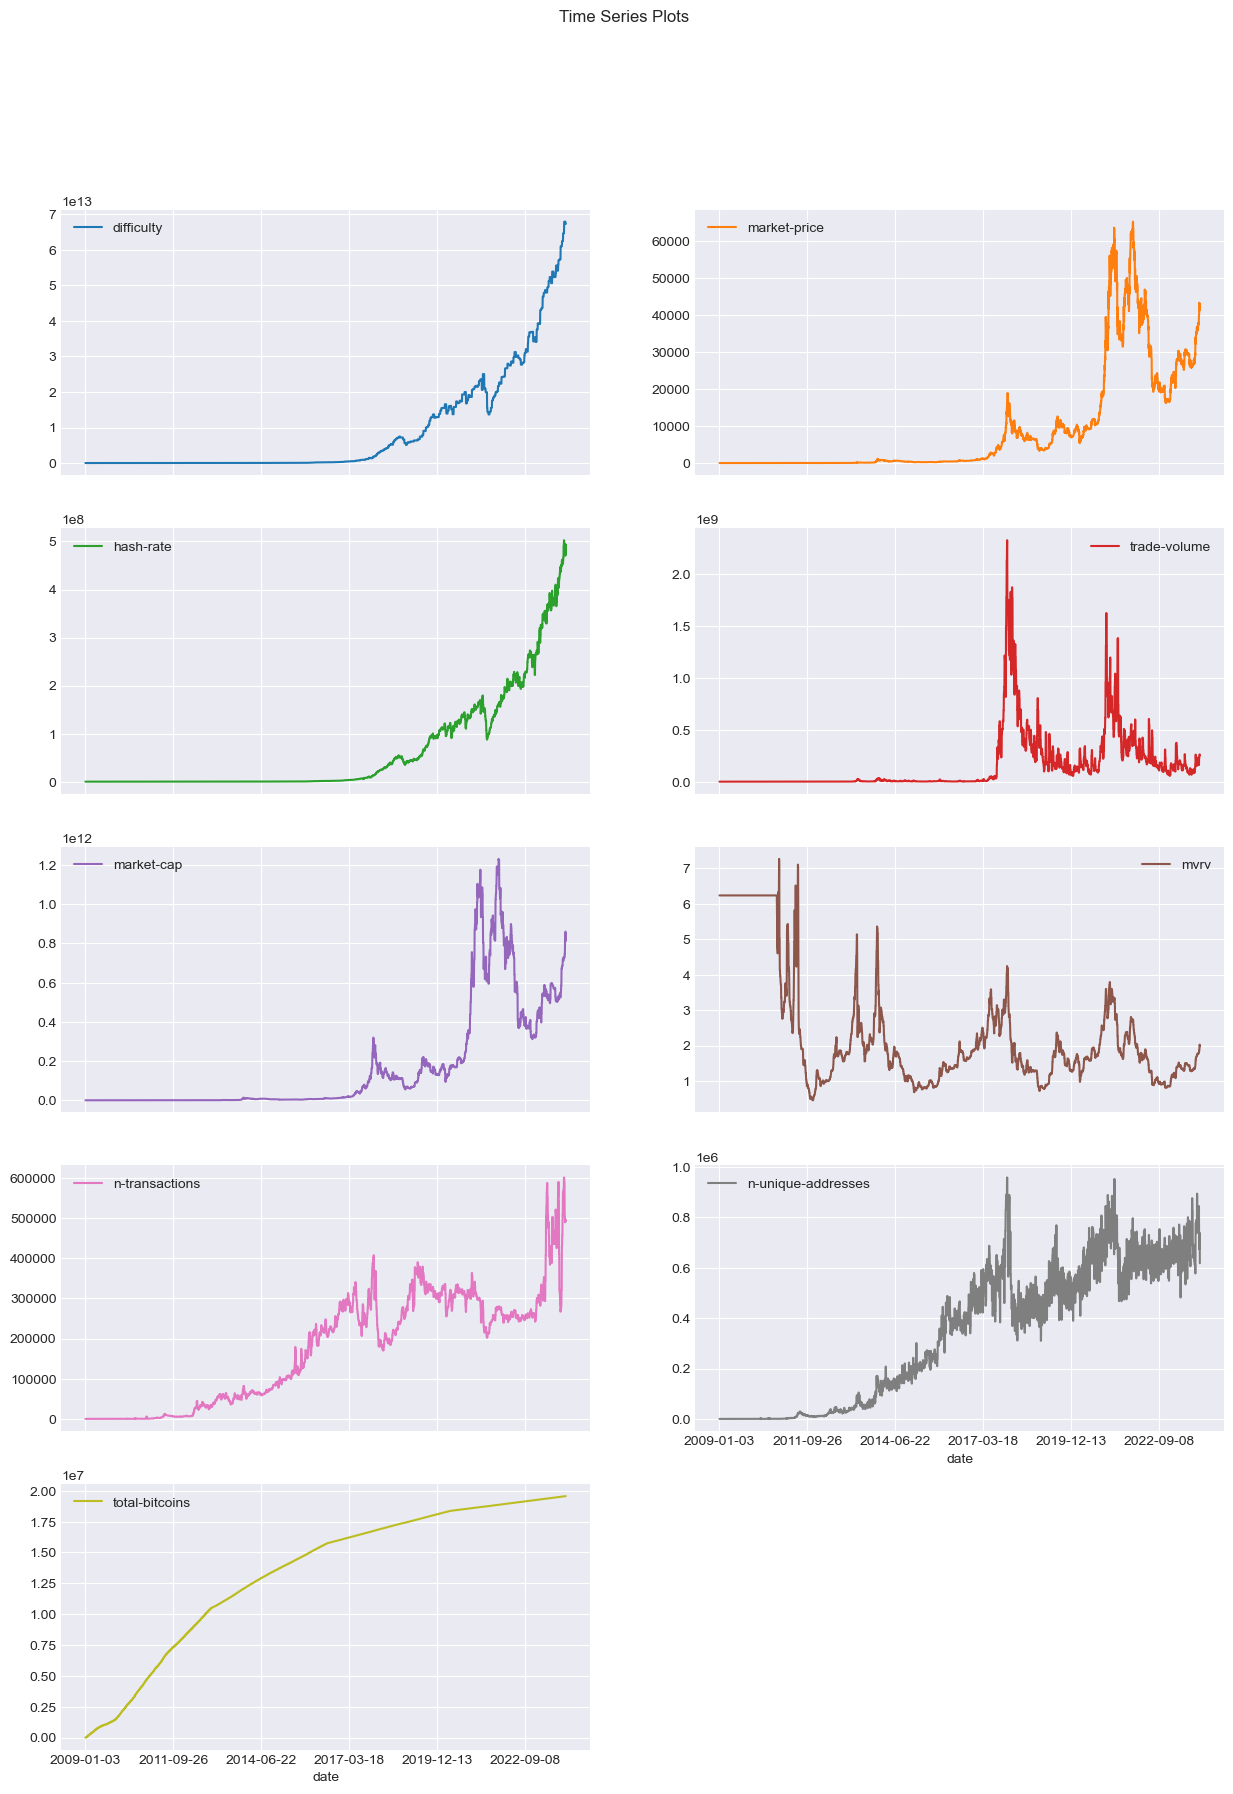

In [134]:
import matplotlib.pyplot as plt

# Set the figure size and plot style
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-v0_8-darkgrid')

# Plotting time series data
df.plot(x='date', y=['difficulty', 'market-price', 'hash-rate', 'trade-volume', 'market-cap', 'mvrv', 'n-transactions', 'n-unique-addresses', 'total-bitcoins'], subplots=True, layout=(5, 2), figsize=(15, 20), title='Time Series Plots')

# Show plot
plt.show()


### Correlation Analysis

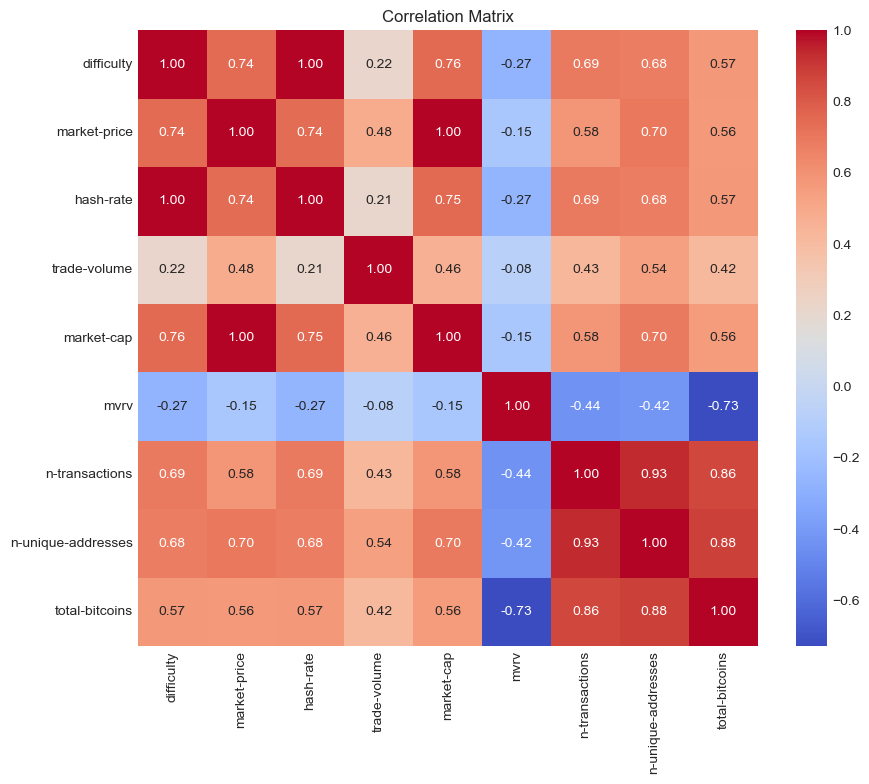

In [135]:
import seaborn as sns

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Distribution of Individual Variables

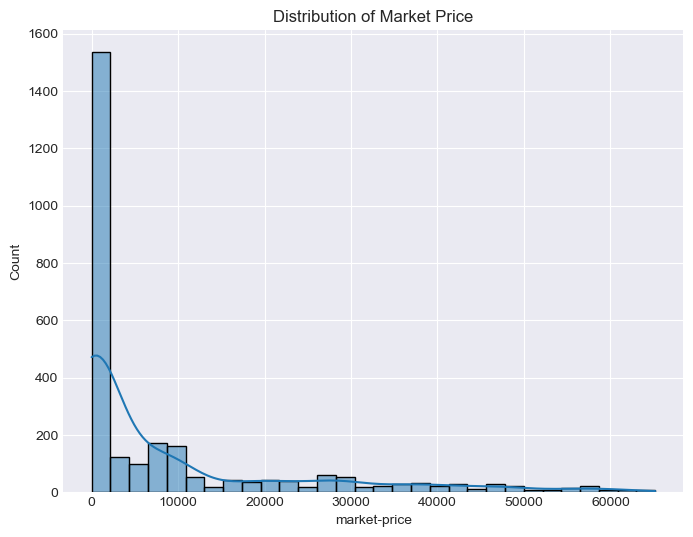

In [136]:
# Distribution of 'market-price'
plt.figure(figsize=(8, 6))
sns.histplot(df['market-price'], bins=30, kde=True)
plt.title('Distribution of Market Price')
plt.show()

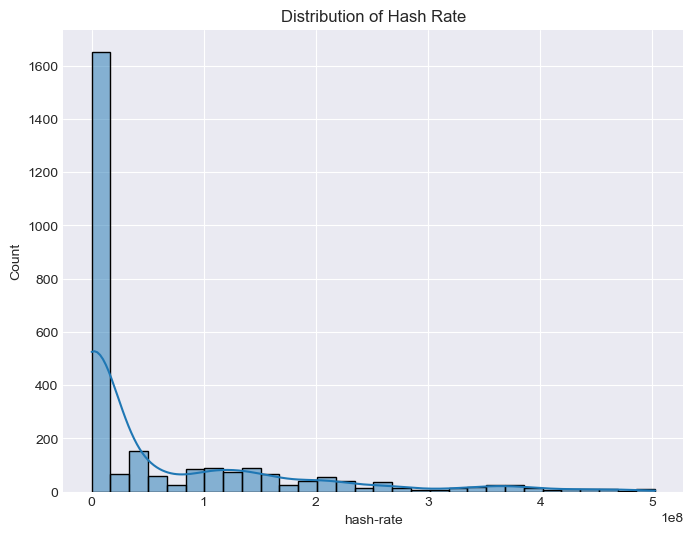

In [137]:
# Distribution of 'hash-rate'
plt.figure(figsize=(8, 6))
sns.histplot(df['hash-rate'], bins=30, kde=True)
plt.title('Distribution of Hash Rate')
plt.show()

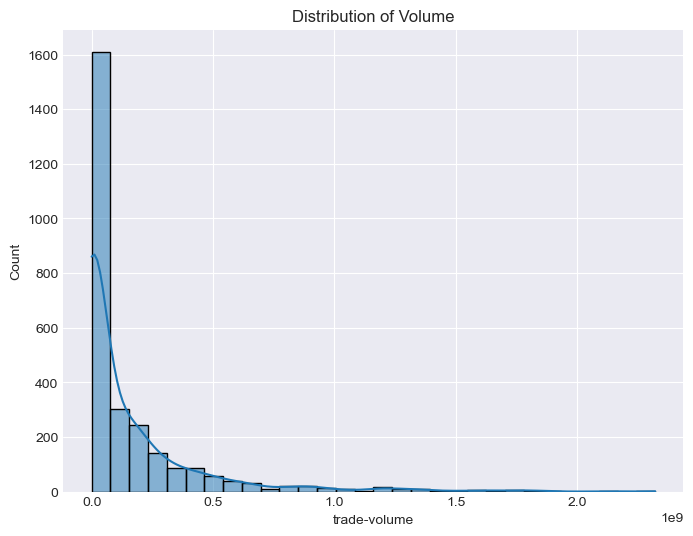

In [138]:
# Distribution of 'volume'
plt.figure(figsize=(8, 6))
sns.histplot(df['trade-volume'], bins=30, kde=True)
plt.title('Distribution of Volume')
plt.show()

### Scatter Plots for Relationships

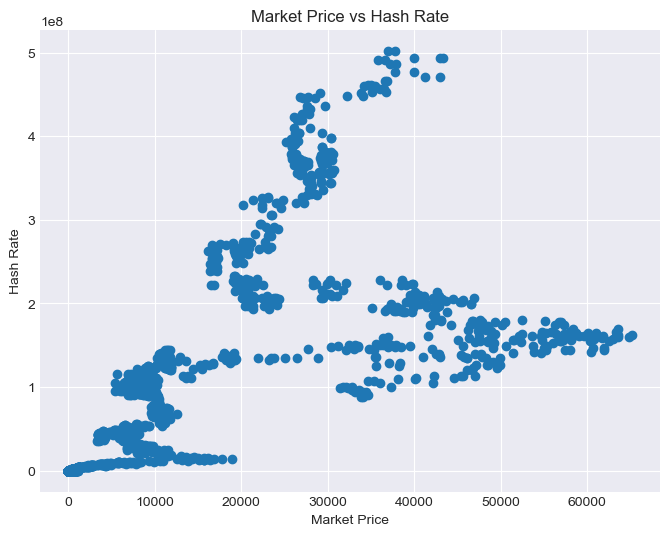

In [139]:
plt.figure(figsize=(8, 6))
plt.scatter(df['market-price'], df['hash-rate'])
plt.xlabel('Market Price')
plt.ylabel('Hash Rate')
plt.title('Market Price vs Hash Rate')
plt.show()

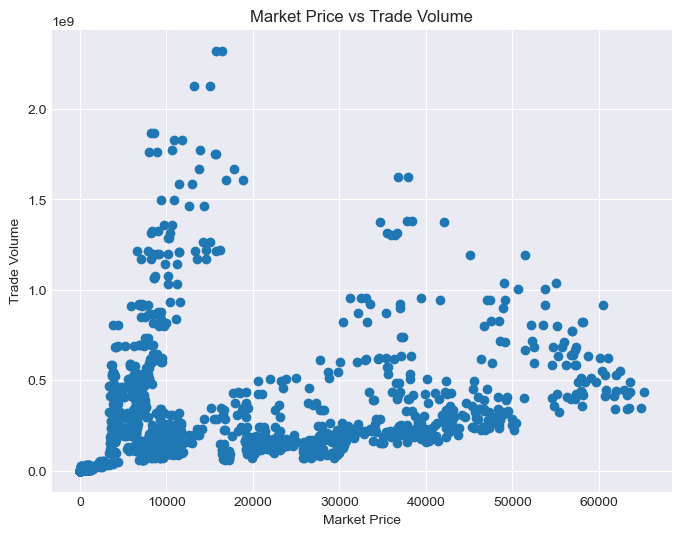

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(df['market-price'], df['trade-volume'])
plt.xlabel('Market Price')
plt.ylabel('Trade Volume')
plt.title('Market Price vs Trade Volume')
plt.show()

## Feature Engineering
Moving Averages, RSI, MACD

### RSI

In [141]:
# Calculate daily price changes
delta = df['market-price'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate the Exponential Moving Average (EMA) for gains and losses
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()

# Calculate the RS
rs = avg_gain / avg_loss

# Calculate the RSI
rsi = 100 - (100 / (1 + rs))

# Add RSI to DataFrame
df['RSI'] = rsi

# Display the DataFrame with RSI
print(df)

            date    difficulty  market-price     hash-rate  trade-volume  \
0     2009-01-03  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
1     2009-01-07  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
3     2009-01-10  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
4     2009-01-11  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
6     2009-01-14  1.000000e+00      0.000000  2.521021e-06  0.000000e+00   
...          ...           ...           ...           ...           ...   
5004  2023-12-07  6.795779e+13  39970.245714  4.941824e+08  2.323577e+08   
5005  2023-12-08  6.795779e+13  43298.700000  4.941824e+08  2.323577e+08   
5008  2023-12-11  6.795779e+13  42996.562857  4.704991e+08  2.618096e+08   
5009  2023-12-12  6.730591e+13  41238.310000  4.704991e+08  2.618096e+08   
5012  2023-12-15  6.730591e+13  42937.712857  4.933132e+08  2.535468e+08   

        market-cap      mvrv  n-transactions  n-unique-addresses  \
0     0.000000e+00 

### Other averages and MACD

In [142]:
# Calculate Simple Moving Averages (SMA)
df['SMA_10'] = df['market-price'].rolling(window=10).mean()  # 10-day SMA
df['SMA_50'] = df['market-price'].rolling(window=50).mean()  # 50-day SMA

''' Use EMA instead of SMA because of the sometimes very rapid variation of price '''

# Calculate Exponential Moving Averages (EMA)
df['EMA_10'] = df['market-price'].ewm(span=10, adjust=False).mean()  # 10-day EMA
df['EMA_50'] = df['market-price'].ewm(span=50, adjust=False).mean()  # 50-day EMA

# MACD (using 12-day EMA and 26-day EMA)
df['MACD'] = df['market-price'].ewm(span=12, adjust=False).mean() - df['market-price'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line

# Display the DataFrame
print(df)

            date    difficulty  market-price     hash-rate  trade-volume  \
0     2009-01-03  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
1     2009-01-07  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
3     2009-01-10  0.000000e+00      0.000000  1.065220e-07  0.000000e+00   
4     2009-01-11  1.000000e+00      0.000000  1.065220e-07  0.000000e+00   
6     2009-01-14  1.000000e+00      0.000000  2.521021e-06  0.000000e+00   
...          ...           ...           ...           ...           ...   
5004  2023-12-07  6.795779e+13  39970.245714  4.941824e+08  2.323577e+08   
5005  2023-12-08  6.795779e+13  43298.700000  4.941824e+08  2.323577e+08   
5008  2023-12-11  6.795779e+13  42996.562857  4.704991e+08  2.618096e+08   
5009  2023-12-12  6.730591e+13  41238.310000  4.704991e+08  2.618096e+08   
5012  2023-12-15  6.730591e+13  42937.712857  4.933132e+08  2.535468e+08   

        market-cap      mvrv  n-transactions  n-unique-addresses  \
0     0.000000e+00 

## Final Clean-up (NaNs from engineered features)

In [143]:
nan_counts = df.isna().sum()
print(nan_counts)

date                    0
difficulty              0
market-price            0
hash-rate               0
trade-volume            0
market-cap              0
mvrv                    0
n-transactions          0
n-unique-addresses      0
total-bitcoins          0
RSI                   298
SMA_10                  9
SMA_50                 49
EMA_10                  0
EMA_50                  0
MACD                    0
Signal_Line             0
dtype: int64


In [144]:
# Make a copy of the DataFrame
df_copy = df.copy()

# Drop rows where there are NaN values in 'RSI', 'SMA_10', or 'SMA_50' columns
df = df.dropna(subset=['RSI', 'SMA_10', 'SMA_50'])

nan_counts = df.isna().sum()
print(nan_counts)

date                  0
difficulty            0
market-price          0
hash-rate             0
trade-volume          0
market-cap            0
mvrv                  0
n-transactions        0
n-unique-addresses    0
total-bitcoins        0
RSI                   0
SMA_10                0
SMA_50                0
EMA_10                0
EMA_50                0
MACD                  0
Signal_Line           0
dtype: int64


## Standardisation

In [145]:
from sklearn.model_selection import train_test_split

features = ['difficulty', 'hash-rate', 'trade-volume', 'market-cap', 'mvrv', 'n-transactions', 'n-unique-addresses', 'total-bitcoins', 'RSI', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'MACD', 'Signal_Line']
X = df[features]
y = df['market-price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)





## SVR

In [146]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Create an SVR model with the RBF kernel
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

# Train the model
svr_rbf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svr_rbf.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  1424.9124661307528


## Visualisations
### Scatter Plot

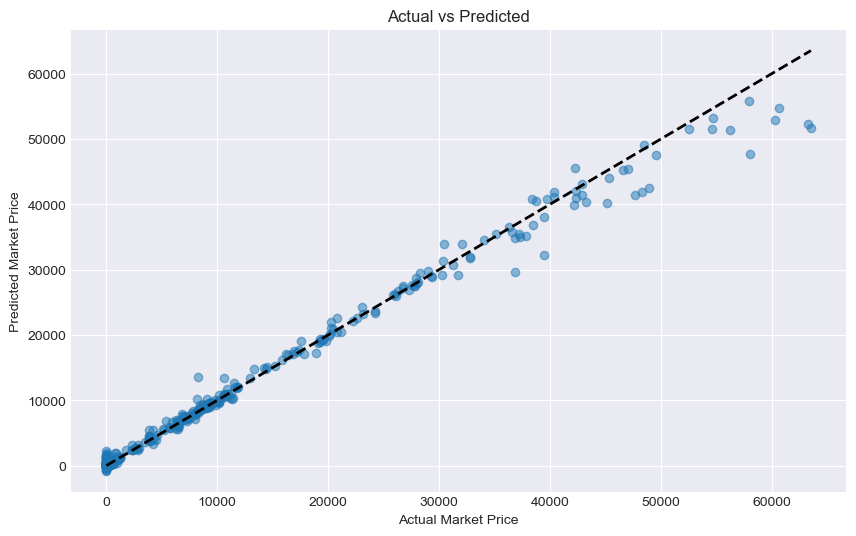

In [147]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Market Price')
plt.ylabel('Predicted Market Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

### Line Plot

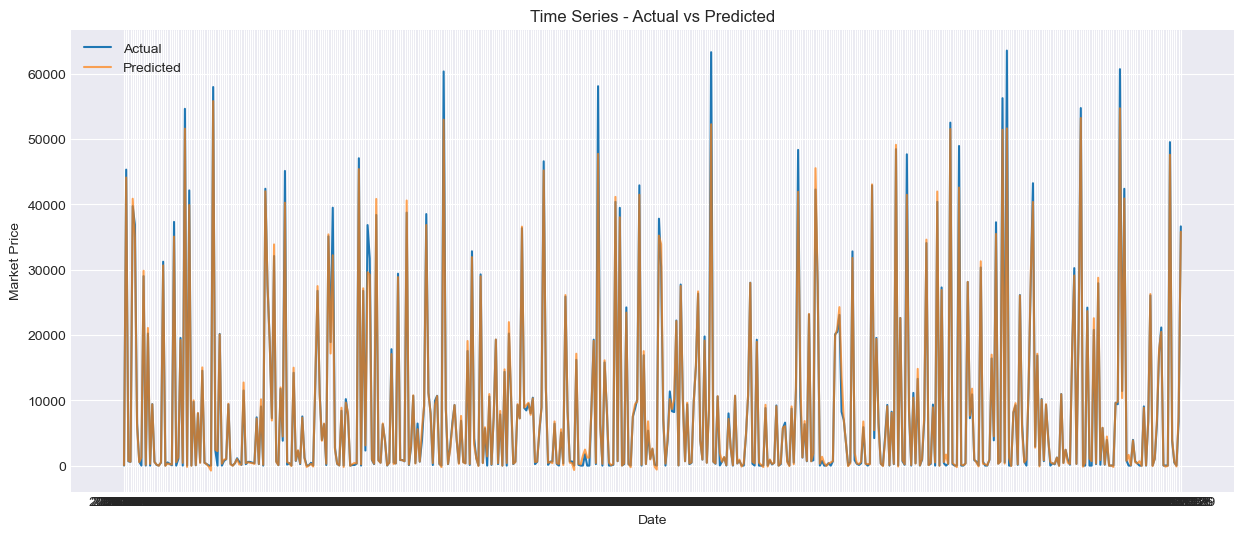

In [148]:
# Create a new DataFrame for testing data
df_test = df.loc[X_test.index]
df_test['Predicted'] = y_pred  # Add your model's predictions

# Sort df_test by date if it's not already sorted
df_test.sort_values('date', inplace=True)

plt.figure(figsize=(15, 6))
plt.plot(df_test['date'], y_test, label='Actual')
plt.plot(df_test['date'], y_pred, label='Predicted', alpha=0.7)
plt.title('Time Series - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Market Price')
plt.legend()
plt.show()

### Error Distribution Plot

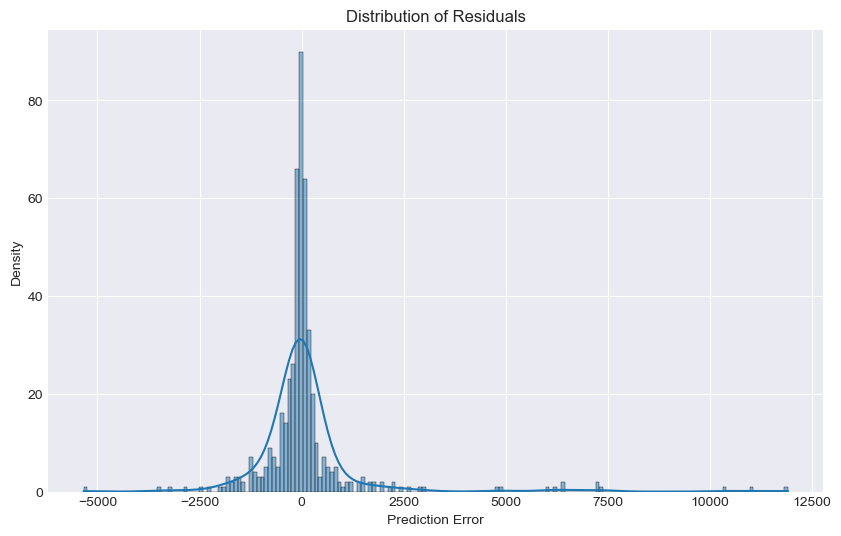

In [149]:
# Calculate the residuals (differences between actual and predicted)
residuals = y_test - y_pred

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.show()


## Other metrics

Given that the value of Bitcoin was zero for so long, I didn't use MAPE - Mean Absolute Percentage Error to avoid division by zero.

### Mean Absolute Error (MAE)

In [150]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 585.0456853855618


MAE not high compared to current Bitcoin price.

### R² (Coefficient of Determination)

In [151]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R² (Coefficient of Determination):", r2)


R² (Coefficient of Determination): 0.9894870237392063


A high R² indicates the model is able to explain most of the variation on the test data.

## Hyperparameter Optimization

### Grid Search

In [152]:
from sklearn.model_selection import GridSearchCV

# Define the model
svr = SVR()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

# Set up the grid search
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform the grid search on training data
#grid_search.fit(X_train, y_train)

# Perform the grid search on a smaller subset of the training data (computation time)
X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, test_size=0.7, random_state=42)
grid_search.fit(X_train_small, y_train_small)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Best score: -890003.1834945432


#### Retraining SVR the model with new hyperparameters

In [153]:
import numpy as np

best_parameters = grid_search.best_params_  

# Create a new SVR model with the best parameters
optimized_svr = SVR(C=best_parameters['C'], kernel=best_parameters['kernel'], gamma=best_parameters['gamma'])

# Train the model on the training data
optimized_svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_optimized = optimized_svr.predict(X_test_scaled)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred_optimized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_optimized)
r2 = r2_score(y_test, y_pred_optimized)

# Print performance metrics
print("Optimized SVR Model Performance:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² (Coefficient of Determination):", r2)


Optimized SVR Model Performance:
Mean Squared Error (MSE): 391122.796819075
Root Mean Squared Error (RMSE): 625.398110661581
Mean Absolute Error (MAE): 248.1428810455953
R² (Coefficient of Determination): 0.9979748255409726


#### Crossvalidation

In [154]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define SVR model (use the optimized hyperparameters)
svr_model = SVR(C=best_parameters['C'], kernel=best_parameters['kernel'], gamma=best_parameters['gamma'])

# Create a pipeline that standardizes the data then fits the model
pipeline = make_pipeline(StandardScaler(), svr_model)

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print the RMSE scores for each fold
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE:", rmse_scores.std())

RMSE scores for each fold: [  83.99532298   40.49640392  356.84715373  921.86107023 1531.90771108]
Mean RMSE: 587.0215323855479
Standard deviation of RMSE: 567.3857126827639


### Random Search

In [155]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Define the model
svr = SVR()

# Define the distribution of hyperparameters to sample from
param_distributions = {
    'C': reciprocal(0.1, 100),
    'gamma': expon(scale=1.0),
    'kernel': ['rbf', 'poly', 'linear']
}

# Set up the random search
random_search = RandomizedSearchCV(svr, param_distributions, n_iter=50, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)

# Perform the random search on training data
# random_search.fit(X_train_scaled, y_train)

# Perform the random search on a smaller subset of the training data (computation time)
random_search.fit(X_train_small, y_train_small)

# Print the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'C': 58.293845429947375, 'gamma': 0.09265545895311562, 'kernel': 'linear'}
Best score: -1279938.664949743


#### Retraining the SVR model with the new hyperparameters

In [156]:
best_parameters = random_search.best_params_  

# Create a new SVR model with the best parameters
optimized_svr = SVR(C=best_parameters['C'], kernel=best_parameters['kernel'], gamma=best_parameters['gamma'])

# Train the model on the training data
optimized_svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_optimized = optimized_svr.predict(X_test_scaled)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred_optimized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_optimized)
r2 = r2_score(y_test, y_pred_optimized)

# Print performance metrics
print("Optimized SVR Model Performance:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² (Coefficient of Determination):", r2)


Optimized SVR Model Performance:
Mean Squared Error (MSE): 406126.076073567
Root Mean Squared Error (RMSE): 637.280217858335
Mean Absolute Error (MAE): 254.13354110957013
R² (Coefficient of Determination): 0.997897140838892


#### Crossvalidation

In [157]:
# Define your SVR model (use the optimized hyperparameters)
svr_model = SVR(C=best_parameters['C'], kernel=best_parameters['kernel'], gamma=best_parameters['gamma'])

# Create a pipeline that standardizes the data then fits the model
pipeline = make_pipeline(StandardScaler(), svr_model)

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print the RMSE scores for each fold
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE:", rmse_scores.std())


RMSE scores for each fold: [  89.99673377   38.89628541  372.98379906  954.25573998 1517.79946978]
Mean RMSE: 594.7864056001107
Standard deviation of RMSE: 564.6581538910004


#### Final model selection

Even though the hyperparameter optimisation was limited due to the subset of data used, both models were consistent in finding the linear kernel as the best one. Grid search seems to have resulted in a lower RMSE. The value for the mean RMSE is not high compared to the current market price of Bitcoin. 

## Deploy

In [158]:
# Let's create some new data as an example
last_row = df[features].iloc[-1] # Extracting the last row of the dataframe for the features
new_data_point = last_row * 1.10 # Selecting the feature columns and increasing their values by 10%

# Print the new data point
print("New data point (increased by 10%):")
print(new_data_point)

# Convert the new data point to a DataFrame with the same feature names
new_data = pd.DataFrame([new_data_point], columns=features)

# Re-create a new SVR model with the best parameters
best_parameters = grid_search.best_params_  
optimized_svr = SVR(C=best_parameters['C'], kernel=best_parameters['kernel'], gamma=best_parameters['gamma'])
optimized_svr.fit(X_train_scaled, y_train)

# Scale the new data using the same scaler as the training data
new_data_scaled = scaler.transform(new_data)

# Make a prediction with the optimized model from Grid Search
new_prediction = optimized_svr.predict(new_data_scaled)

# Print the predicted market price
print("Predicted market price for the input data:", new_prediction[0])

New data point (increased by 10%):
difficulty            7.403650e+13
hash-rate             5.426445e+08
trade-volume          2.789015e+08
market-cap            8.934292e+11
mvrv                  2.180141e+00
n-transactions        5.411249e+05
n-unique-addresses    6.796889e+05
total-bitcoins        2.152463e+07
RSI                   7.941860e+01
SMA_10                4.412576e+04
SMA_50                3.557951e+04
EMA_10                4.452101e+04
EMA_50                3.776210e+04
MACD                  3.037274e+03
Signal_Line           2.721693e+03
Name: 5012, dtype: float64
Predicted market price for the input data: 46382.81249330302


In [159]:
from joblib import dump, load

# Save the model to a file
filename = 'optimized_svr_model.joblib'
dump(optimized_svr, filename)
print(f"Model saved to {filename}")

# Load the model back in
loaded_model = load(filename)


# Make a prediction with the loaded model
new_prediction = loaded_model.predict(new_data_scaled)
print("Predicted market price for the input data:", new_prediction[0])

Model saved to optimized_svr_model.joblib
Predicted market price for the input data: 46382.81249330302
